In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import pypsa
from pathlib import Path
import sys
sys.path.append(str(Path.cwd() / ".." / "scripts"))

n = pypsa.Network(Path.cwd()
                  / "egs_test" 
                  / "postnetworks"
                  / "elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc"
                  )

INFO:pypsa.io:Imported network elec_s_37_lcopt__Co2L0-180H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


##### Geothermal Map

In [120]:
import yaml
cfg_file = Path.cwd() /  ".." / "config.default.yaml"
with open(cfg_file, "r") as f:
    config = yaml.safe_load(f)
with open(cfg_file, "r") as f:
    tech_colors = pd.Series(yaml.safe_load(f)["plotting"]["tech_colors"])

tech_colors.loc["battery discharger"] = "#ace37f"
tech_colors.loc["urban central solid biomass CHP"] = "#baa741"
tech_colors.loc["urban central gas CHP CC"] = "#692e0a"
tech_colors.loc["urban central gas CHP"] = "#692e0a"
tech_colors.loc["urban central solid biomass CHP CC"] = "#47411c"
tech_colors.loc["DC"] = tech_colors.loc["transmission lines"]
tech_colors.loc["urban central solar thermal"] = tech_colors.loc["solar thermal"]
tech_colors.loc["urban central water tanks discharger"] = tech_colors.loc["water tanks"]
tech_colors.loc["urban central resistive heater"] = tech_colors.loc["resistive heater"]
tech_colors.loc["urban central air heat pump"] = tech_colors.loc["heat pump"]
tech_colors.loc["urban central gas boiler"] = tech_colors.loc["gas"]


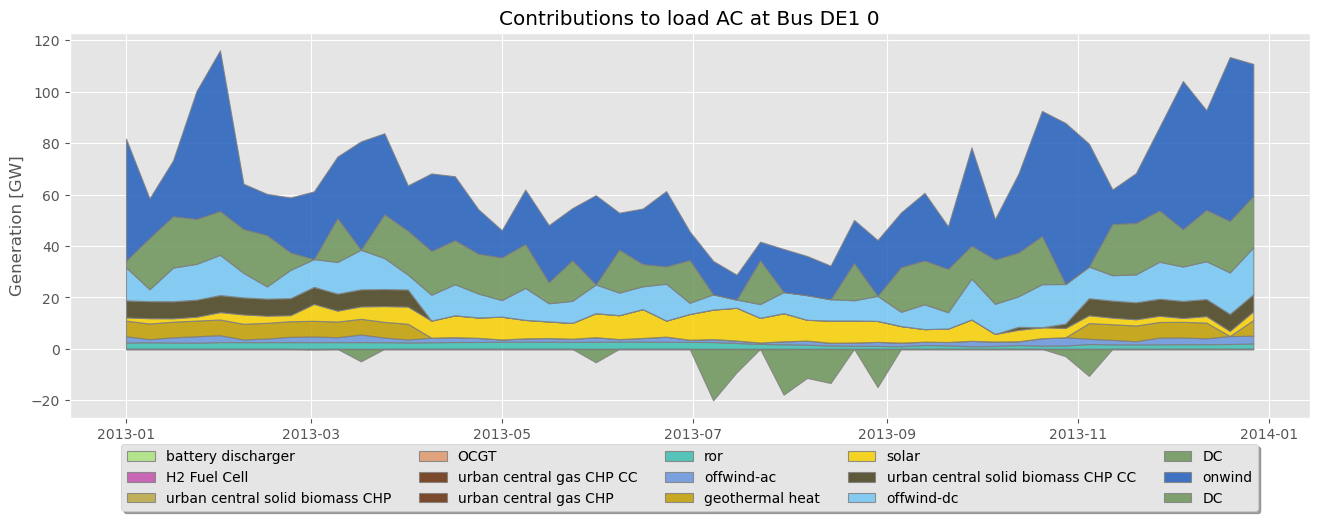

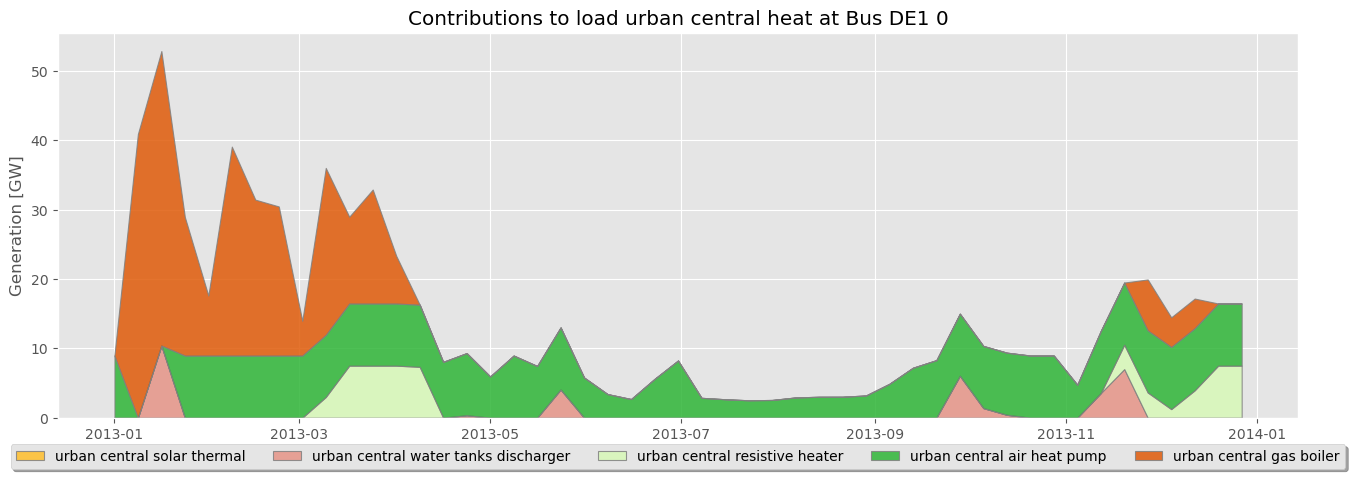

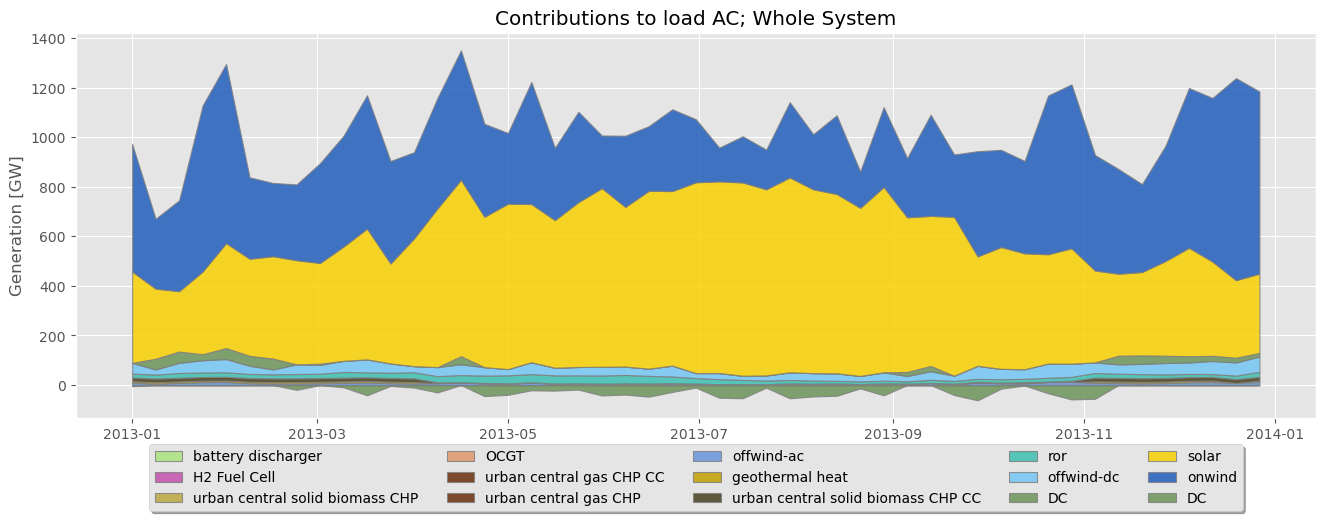

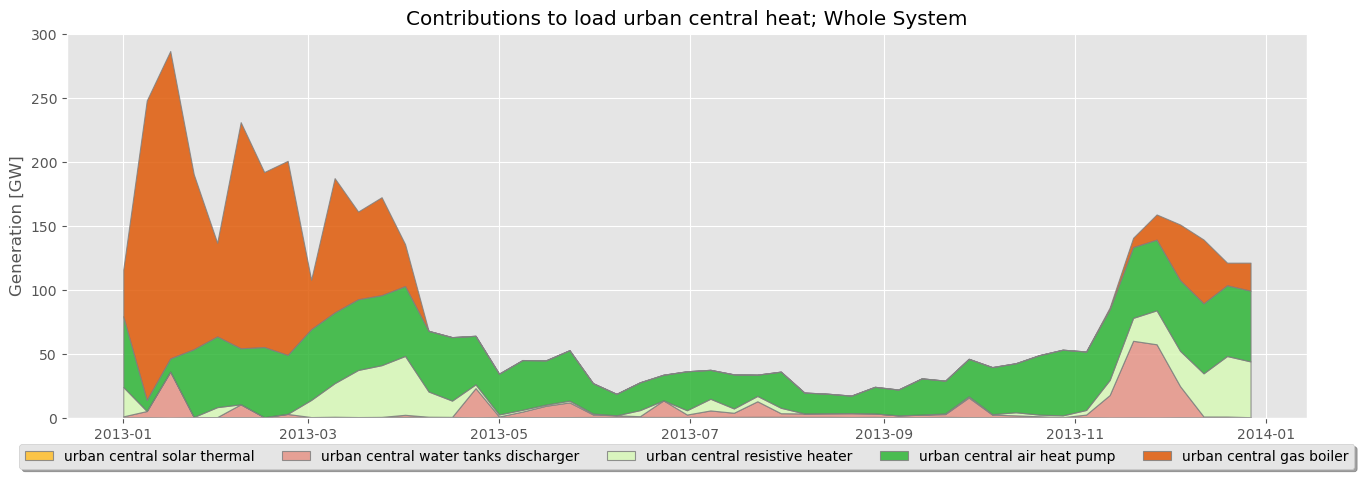

In [230]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")


def plot_timeseries(plot_bus, plot_carrier):

    if not plot_bus == "all":
        buses = n.buses.loc[n.buses.location == plot_bus]
    else:
        buses = n.buses

    buses = buses.loc[buses.carrier == plot_carrier].index.tolist()

    energy_inflows = pd.DataFrame(index=n.generators_t.p.index)
    inflow_links = n.links.loc[n.links.bus1.isin(buses)]

    for carrier in inflow_links.carrier.unique():
        mask = inflow_links.carrier == carrier
        carrier_primary_flow = n.links_t.p0[inflow_links.loc[mask].index]

        efficiency = n.links.loc[inflow_links.loc[mask].index].efficiency

        energy_inflows[carrier] = n.links_t.p0[
            inflow_links.loc[mask].index
            ].multiply(efficiency).sum(axis=1)

        carrier_flow = n.links_t.p0[
            inflow_links.loc[mask].index
            ].multiply(efficiency)
        
        energy_inflows[carrier] = carrier_flow.sum(axis=1)

    gens = n.generators.loc[n.generators.bus.isin(buses)]

    for carrier in gens.carrier.unique():
        if carrier in energy_inflows.columns:
            energy_inflows[carrier] += n.generators_t.p[gens.loc[n.generators.carrier == carrier].index].sum(axis=1)
        else:
            energy_inflows[carrier] = n.generators_t.p[gens.loc[n.generators.carrier == carrier].index].sum(axis=1)

    # linkflow = n.links_t.p0[feedings]
    energy_inflows = energy_inflows * 1e-3

    energy_outflows = pd.DataFrame(np.minimum(energy_inflows.values, np.zeros_like(energy_inflows)),
                                index=energy_inflows.index, columns=energy_inflows.columns)
    energy_outflows = energy_outflows[energy_outflows.sum().loc[energy_outflows.sum() < 0.].index]

    energy_inflows = pd.DataFrame(np.maximum(energy_inflows.values, np.zeros_like(energy_inflows)),
                                index=energy_inflows.index, columns=energy_inflows.columns)
    energy_inflows = energy_inflows[energy_inflows.std().sort_values().index]

    fig, ax = plt.subplots(1, 1, figsize=(16, 5))

    ax.stackplot(energy_inflows.index,
                list(energy_inflows.values.T), 
                edgecolor="grey",
                linewidth=.8,
                alpha=0.85,
                colors=tech_colors.loc[energy_inflows.columns].values,
                labels=energy_inflows.columns)

    if not energy_outflows.empty:
        ax.stackplot(energy_outflows.index,
                    list(energy_outflows.values.T),
                    edgecolor="grey",
                    linewidth=.8,
                    alpha=0.85,
                    colors=tech_colors.loc[energy_outflows.columns].values,
                    labels=energy_outflows.columns)


    ax.set_xlabel("Datetime")
    ax.set_ylabel("Generation [GW]")
    ax.legend(
        loc="upper center", bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5
    )

    if plot_bus == "all":
        ax.set_title(f"Contributions to load {plot_carrier}; Whole System")
    else:
        ax.set_title(f"Contributions to load {plot_carrier} at Bus {plot_bus}")

    plt.show()


plot_timeseries("DE1 0", "AC")
plot_timeseries("DE1 0", "urban central heat")
plot_timeseries("all", "AC")
plot_timeseries("all", "urban central heat")

/tmp/ipykernel_20795/1924194906.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gens["total_costs"] = gens.loc[:, "capital_cost"] * gens.loc[:, "p_nom_opt"]
/tmp/ipykernel_20795/1924194906.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  links["total_costs"] = links.loc[:, "capital_cost"] * links.loc[:, "p_nom_opt"]
/home/lukas/mambaforge/envs/pypsa-eur/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn

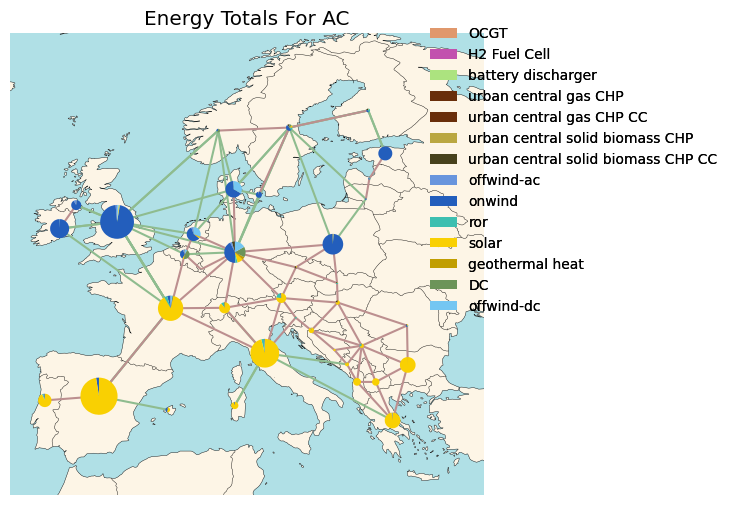

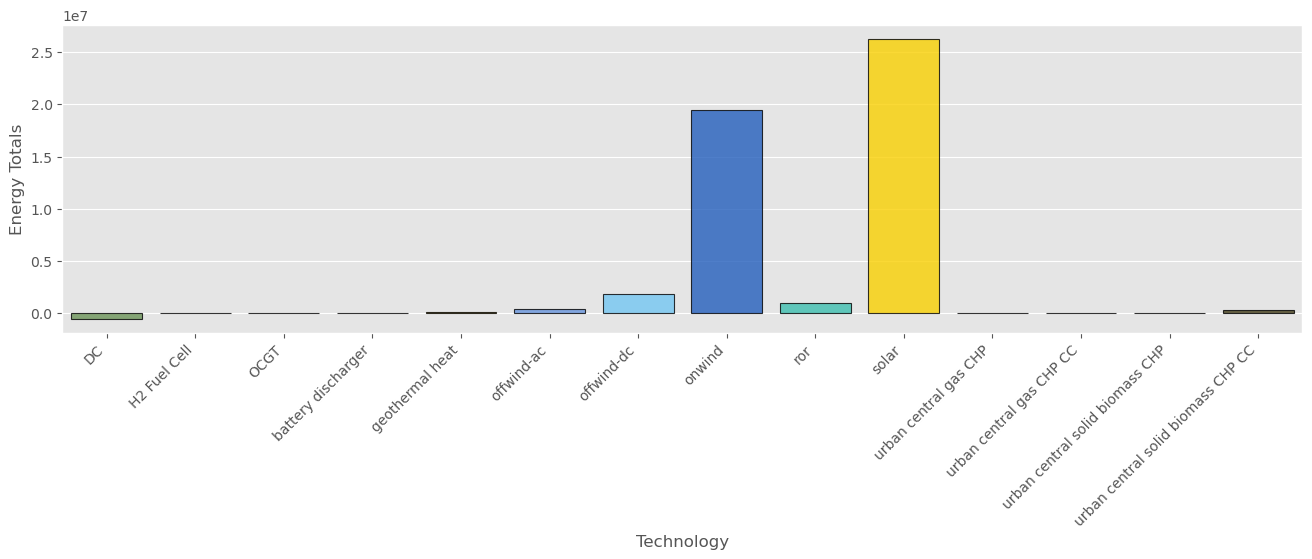

/home/lukas/mambaforge/envs/pypsa-eur/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


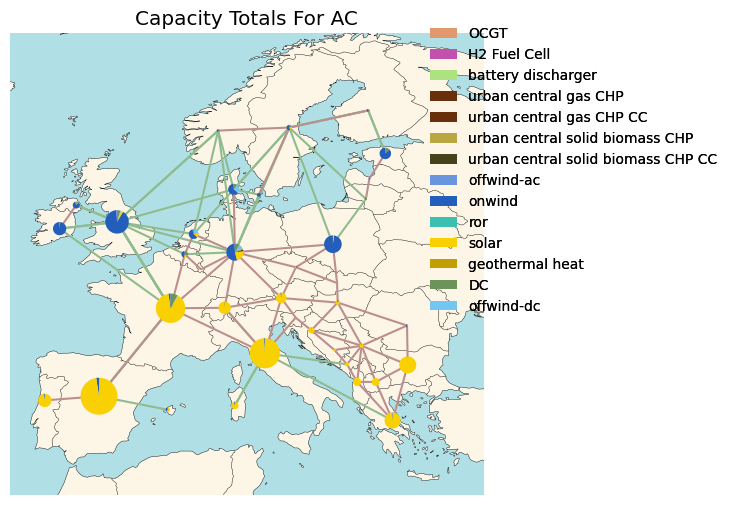

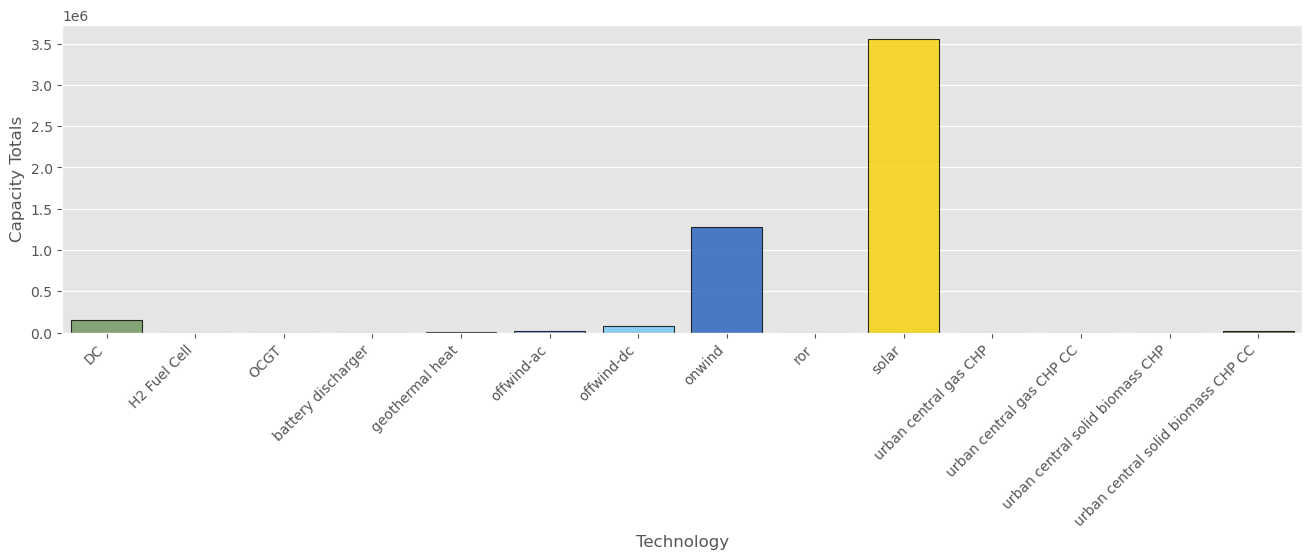

/home/lukas/mambaforge/envs/pypsa-eur/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


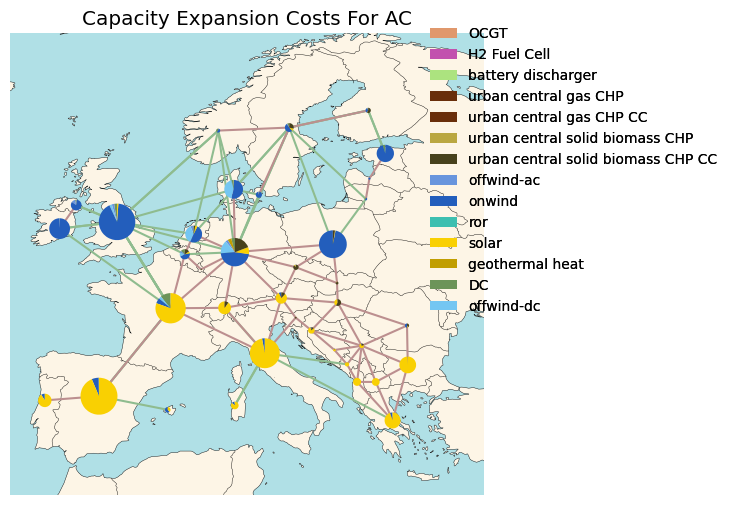

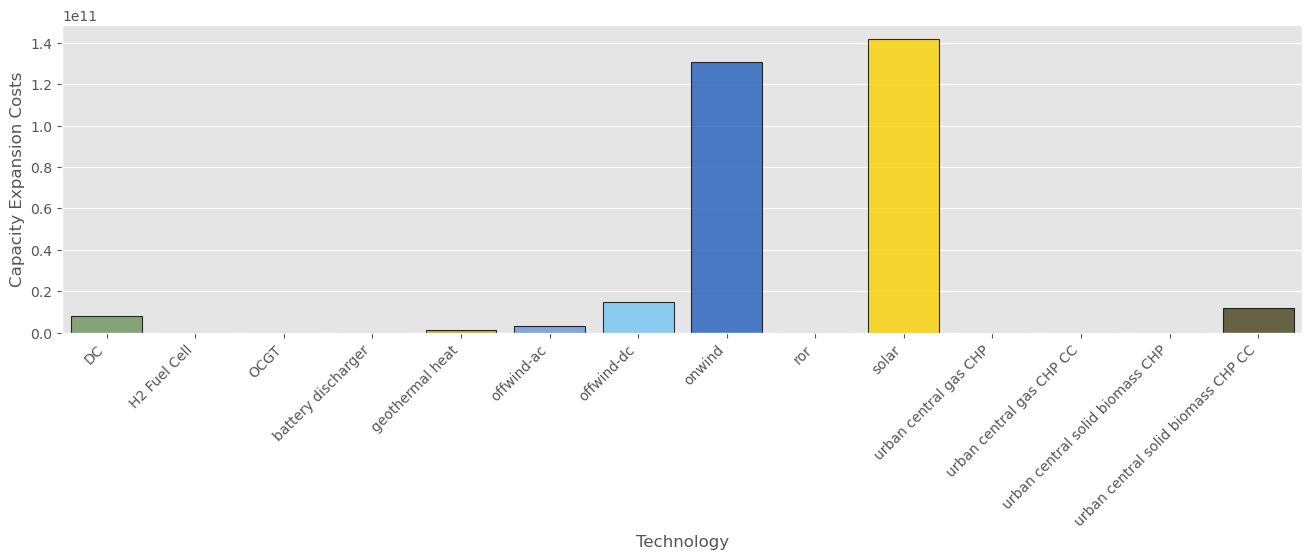

/tmp/ipykernel_20795/1924194906.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gens["total_costs"] = gens.loc[:, "capital_cost"] * gens.loc[:, "p_nom_opt"]
/tmp/ipykernel_20795/1924194906.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  links["total_costs"] = links.loc[:, "capital_cost"] * links.loc[:, "p_nom_opt"]
/home/lukas/mambaforge/envs/pypsa-eur/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn

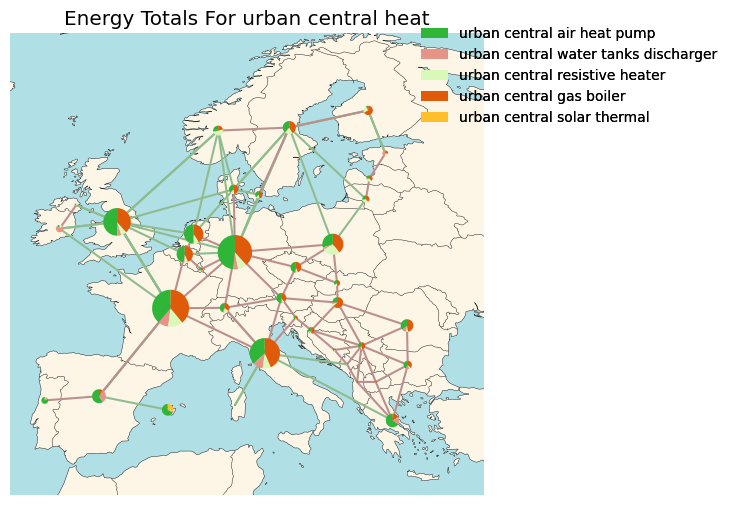

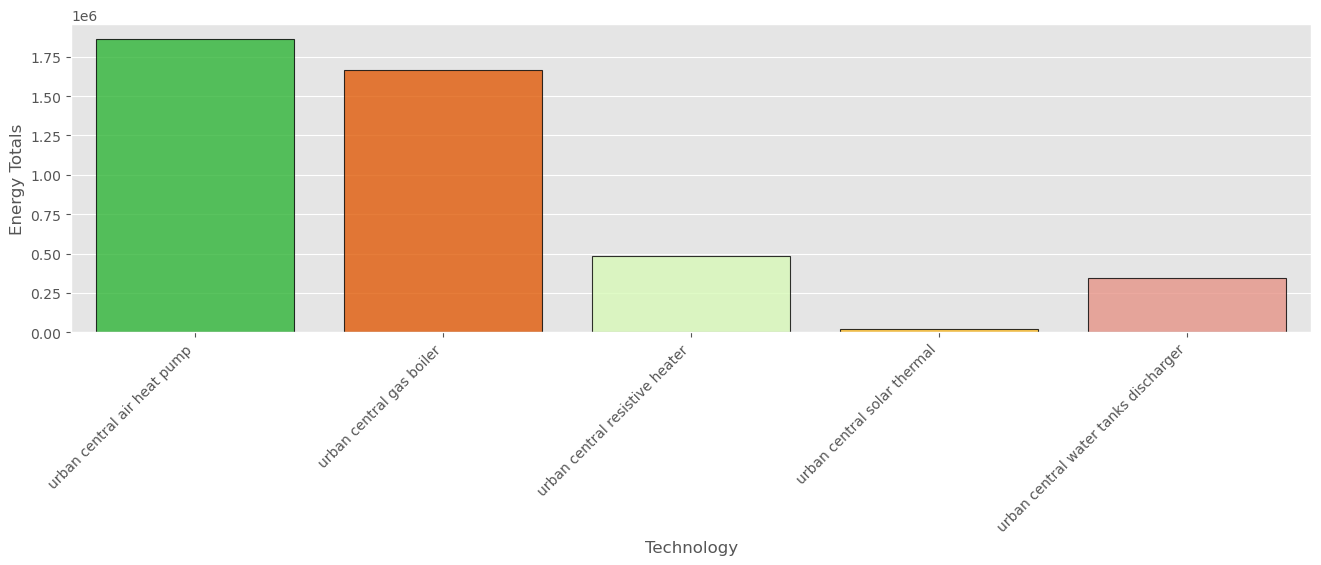

/home/lukas/mambaforge/envs/pypsa-eur/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


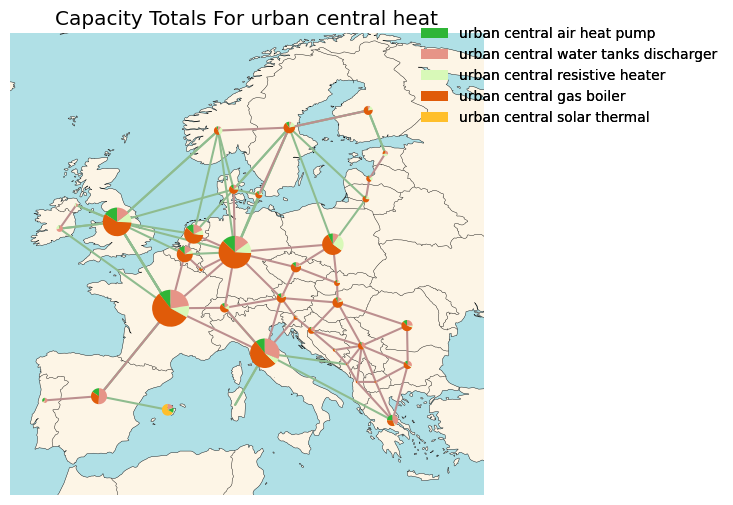

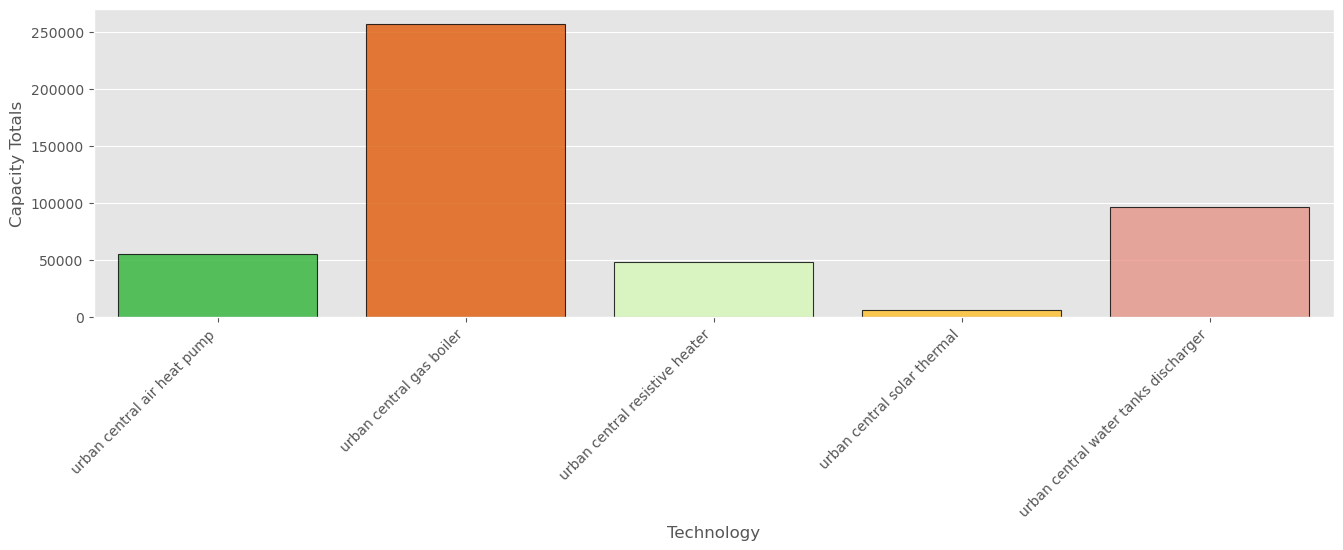

/home/lukas/mambaforge/envs/pypsa-eur/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


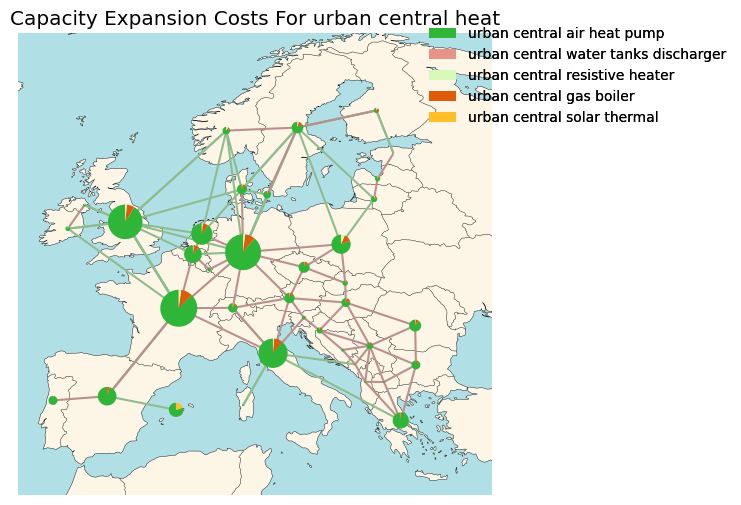

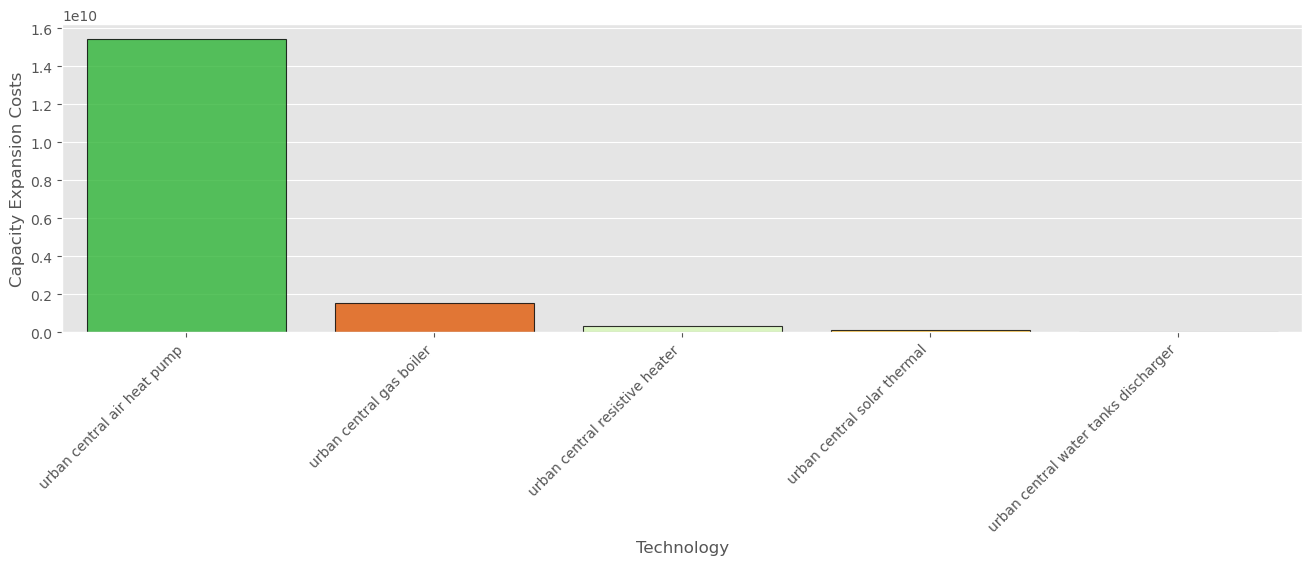

In [287]:
import seaborn as sns
import cartopy.crs as ccrs
import geopandas as gpd
import pandas as pd
import numpy as np
import pypsa
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from pathlib import Path
from pypsa.plot import add_legend_patches

from plot_network import rename_techs_tyndp


def assign_location(n):
    for c in n.iterate_components(n.one_port_components | n.branch_components):
        ifind = pd.Series(c.df.index.str.find(" ", start=4), c.df.index)
        for i in ifind.value_counts().index:
            # these have already been assigned defaults
            if i == -1:
                continue
            names = ifind.index[ifind == i]
            c.df.loc[names, "location"] = names.str[:i]


def plot_geothermal_map(network, loadpoint):

    max_piechart_size = 3.  

    n = network.copy()
    assign_location(n)

    map_opts = config["plotting"]["map"]
    map_opts["color_geomap"]["ocean"] = "powderblue"
    map_opts["color_geomap"]["land"] = "oldlace"
    
    buses = n.buses.loc[n.buses.carrier == loadpoint].index.to_list()
    energy_totals = list()
    capacity_totals = list()

    costs = pd.DataFrame(index=buses)

    gens = n.generators.loc[n.generators.bus.isin(buses)]
    gens["total_costs"] = gens.loc[:, "capital_cost"] * gens.loc[:, "p_nom_opt"]
    
    links = n.links.loc[n.links.bus1.isin(buses)]
    links["total_costs"] = links.loc[:, "capital_cost"] * links.loc[:, "p_nom_opt"]
    links = links.rename(columns={"bus1": "bus"})

    
    costs = pd.concat((
        gens[["bus", "carrier", "total_costs"]], links[["bus", "carrier", "total_costs"]],
    ), ignore_index=True)

    costs["bus"] = costs["bus"].apply(lambda bus: n.buses.at[bus, "location"])
    costs = costs.groupby(["bus", "carrier"]).sum()["total_costs"]
    
    for bus in buses:

        energy_inflows = pd.DataFrame(index=n.generators_t.p.index)
        inflow_links = n.links.loc[n.links.bus1 == bus]

        for carrier in inflow_links.carrier.unique():
            mask = inflow_links.carrier == carrier

            efficiency = n.links.loc[inflow_links.loc[mask].index].efficiency

            energy_inflows[carrier] = n.links_t.p0[
                inflow_links.loc[mask].index
                ].multiply(efficiency).sum(axis=1)

            carrier_flow = n.links_t.p0[
                inflow_links.loc[mask].index
                ].multiply(efficiency)
            
            energy_inflows[carrier] = carrier_flow.sum(axis=1)

        gens = n.generators.loc[n.generators.bus == bus]
        links = n.links.loc[n.links.bus1 == bus]

        for carrier in gens.carrier.unique():
            if carrier in energy_inflows.columns:
                energy_inflows[carrier] += n.generators_t.p[gens.loc[n.generators.carrier == carrier].index].sum(axis=1)
            else:
                energy_inflows[carrier] = n.generators_t.p[gens.loc[n.generators.carrier == carrier].index].sum(axis=1)
        
        energy_totals.append(energy_inflows.sum())
        
        subset = gens[["carrier", "p_nom_opt"]]
        gen_capacities = subset.groupby("carrier").sum().p_nom_opt
        subset = links[["carrier", "p_nom_opt", "efficiency"]]
        links_capacities = subset.groupby("carrier").sum().p_nom_opt.multiply(
            subset.groupby("carrier").mean().efficiency
        )

        capacity_totals.append(
            pd.concat((gen_capacities, links_capacities), axis=0)
        )

    energy_totals = pd.concat(energy_totals, axis=1).fillna(0).transpose()
    capacity_totals = pd.concat(capacity_totals, axis=1).fillna(0).transpose()

    energy_totals.index = buses
    capacity_totals.index = buses

    proj = ccrs.EqualEarth()

    # regions = regions.to_crs(proj.proj4_init)

    """
    linewidth_factor = 0
    line_lower_threshold = 0
    
    ac_color = "rosybrown"
    dc_color = "darkseagreen"

    line_widths = n.lines.s_nom_opt - n.lines.s_nom
    link_widths = n.links.p_nom_opt - n.links.p_nom
    """
    
    # hack because impossible to drop buses...
    eu_location = config["plotting"].get(
        "eu_node_location", dict(x=-5.5, y=46)
    )
    n.buses.loc["EU gas", "x"] = eu_location["x"]
    n.buses.loc["EU gas", "y"] = eu_location["y"]
    n.links.drop(
        n.links.index[(n.links.carrier != "DC") & (n.links.carrier != "B2B")],
        inplace=True,
    )

    energy_totals.index = n.buses.loc[buses].location
    energy_totals.index.name = None
    capacity_totals.index = n.buses.loc[buses].location
    capacity_totals.index.name = None

    carriers = energy_totals.columns

    energy_totals = energy_totals.stack()
    capacity_totals = capacity_totals.stack()

    n.buses.drop(n.buses.index[n.buses.carrier != "AC"], inplace=True)

    for quantity, title in zip(
        
        [energy_totals, capacity_totals, costs], 
        ["Energy Totals", "Capacity Totals", "Capacity Expansion Costs"]):
        fig, ax = plt.subplots(subplot_kw={"projection": proj})
        fig.set_size_inches(7, 6)
    
        bus_sizes = quantity / quantity.groupby(level=0).sum().max() * max_piechart_size

        n.plot(
            bus_sizes=bus_sizes,
            bus_colors=tech_colors,
            ax=ax,
            **map_opts,
        )
        ax.set_title(title + f" For {loadpoint}")

        legend_kw = dict(
            bbox_to_anchor=(1.52, 1.04),
            frameon=False,
        )

        colors = [tech_colors[c] for c in carriers]
        labels = carriers

        add_legend_patches(
            ax,
            colors,
            labels,
            legend_kw=legend_kw,
        )

        plt.show()

        fig, ax = plt.subplots(1, 1, figsize=(16, 4))

        barchart_df = pd.DataFrame(index=quantity.groupby(level=1).sum().index)
        barchart_df["value"] = quantity.groupby(level=1).sum()
        barchart_df["x"] = barchart_df.index
         
        sns.barplot(data=barchart_df,
                    y="value",
                    x="x",
                    ax=ax,
                    edgecolor="k",
                    linewidth=.8,
                    )
        
        for bar, tech in zip(ax.patches, barchart_df.index):
            bar.set_color(tech_colors[tech])
            bar.set_edgecolor("k")
            bar.set_linewidth(.8)
            bar.set_alpha(.8)

        ax.set_ylabel(title)
        ax.set_xlabel("Technology")
        
        ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha="right")
        plt.show()

regions = gpd.read_file(Path.cwd() / ".." / ".." / "resource_backups" / "resources" / "egs_test" /
    "regions_onshore_elec_s_37.geojson")

regions.index = regions.name
regions = regions.drop(columns="name")
regions.head()

plot_geothermal_map(n, "AC")
plot_geothermal_map(n, "urban central heat")

/tmp/ipykernel_16730/429646998.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pnomopt = gt.groupby("bus1").sum()[["p_nom_opt"]] * 1e-3 * 0.1


       p_nom_opt   bus1
bus1                   
AT1 0  24.062368  AT1 0
BA1 0   2.170482  BA1 0
BE1 0   2.358283  BE1 0
BG1 0  23.417736  BG1 0
CH1 0  26.762701  CH1 0


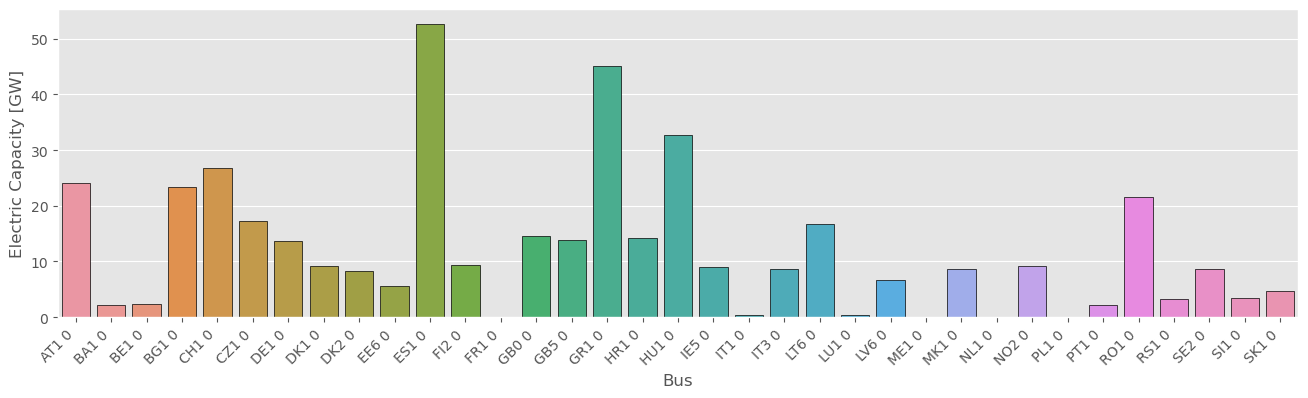

In [115]:
import seaborn as sns


def get_geothermal_capacity_barchart(n):
    
    gt = n.links.loc[n.links.index.str.contains("production well")]
    pnomopt = gt.groupby("bus1").sum()[["p_nom_opt"]] * 1e-3 * 0.1
    pnomopt["bus1"] = pnomopt.index
    
    print(pnomopt.head())

    fig, ax = plt.subplots(1, 1, figsize=(16, 4))

    sns.barplot(data=pnomopt,
                y="p_nom_opt",
                x="bus1",
                ax=ax,
                edgecolor="k", 
                )

    ax.set_ylabel("Electric Capacity [GW]")
    ax.set_xlabel("Bus")
    
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha="right")
    plt.show()



get_geothermal_capacity_barchart(hold)